![](https://www.dii.uchile.cl/wp-content/uploads/2021/06/Magi%CC%81ster-en-Ciencia-de-Datos.png)


# Proyecto: Riesgo en el Banco Giturra

**MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**

### Cuerpo Docente:

- Profesor: Gabriel Iturra, Ignacio Meza De La Jara
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Estudiante:
- Mario González Otero

### Link de repositorio de GitHub:
- [ENLACE](https://github.com/mgzotero/MDS7202)

_Por favor, lean detalladamente las instrucciones de la tarea antes de empezar a escribir._

---

## Reglas

- Fecha de entrega: 19/12/2023
- **Grupos de 2 personas.**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Estrictamente prohibida la copia.
- Pueden usar cualquier material del curso que estimen conveniente.


---


# Presentación del Problema


![](https://www.diarioeldia.cl/u/fotografias/fotosnoticias/2019/11/8/67218.jpg)


**Giturra**, un banquero astuto y ambicioso, estableció su propio banco con el objetivo de obtener enormes ganancias. Sin embargo, su reputación se vio empañada debido a las tasas de interés usureras que imponía a sus clientes. A medida que su banco crecía, Giturra enfrentaba una creciente cantidad de préstamos impagados, lo que amenazaba su negocio y su prestigio.

Para abordar este desafío, Giturra reconoció la necesidad de reducir los riesgos de préstamo y mejorar la calidad de los préstamos otorgados. Decidió aprovechar la ciencia de datos y el análisis de riesgo crediticio. Contrató a un equipo de expertos para desarrollar un modelo predictivo de riesgo crediticio.

Cabe señalar que lo modelos solicitados por el banquero deben ser interpretables. Ya que estos le permitira al equipo comprender y explicar cómo se toman las decisiones crediticias. Utilizando visualizaciones claras y explicaciones detalladas, pudieron identificar las características más relevantes, le permitirá analizar la distribución de la importancia de las variables y evaluar si los modelos son coherentes con el negocio.

Para esto Giturra les solicita crear un modelo de riesgo disponibilizandoles una amplia gama de variables de sus usuarios: como historiales de crédito, ingresos y otros factores financieros relevantes, para evaluar la probabilidad de incumplimiento de pago de los clientes. Con esta información, Giturra podra tomar decisiones más informadas en cuanto a los préstamos, ofreciendo condiciones más favorables a aquellos con menor riesgo de impago.


## 1. Introducción

- El Problema planteado es predecir si un cliente es apto para un crédito o no, para esto se cuenta con un dataset de 12500 registros y 22 variables, donde la variable objetivo es `credit_score` que indica si el cliente incumplirá su pago o no.
- Los datos de entrada incluyen características a nivel de cliente, describiendo variadamente su comportamiento financiero y crediticio, además de ciertos datos demográficos, considerando por ejemplo su edad, su salario, su comportamiento de pago, entre otros.
- En el caso de las métricas de rendimiento, sería muy `naïve` considerar unicamente el `accuracy`, dado a que se presenta un caso de desbalance de clases, por lo que se considerará la métrica `f1-score` para evaluar el rendimiento de los modelos, debido a que esta métrica considera tanto la precisión como el recall, lo que permite evaluar el rendimiento de los modelos de manera más completa.
- Se probaron distintos modelos de clasificación, incluyendo un baseline `Dummy`, `LogisticRegression`, `KNeighborsClassifier`, `SVC`, `LightGBMClassifier` y `XGBClassifier`, donde se realizaron distintas transformaciones de los datos, incluyendo `OneHotEncoding` y `RobustScaler`, además de imputación de datos faltantes con `KNNImputer` de manera personalizada.
- Si bien los resultados asociados a la métrica escogida fueron mediocres, se destaca que la diferencia de rendimiento entre el mejor modelo y el baseline es considerable, por lo que se considera que el modelo es aceptable, pero se podría mejorar con más tiempo de trabajo.


## 2. Carga de datos Análisis Exploratorio de Datos

Con el objetivo de entender mejor los datos, se realiza un análisis exploratorio de los datos, con el fin de entender mejor las variables y su comportamiento, además de identificar posibles problemas en los datos. Este análisis se realiza en base a un archivo de `profiling` adjunto al directorio, el cual muestra un análisis descriptivo en formato `web` de las variables del dataset.

De este archivo se desprenden los siguientes puntos:
- Hay variables que a priori debiesen ser no negativas, pero que en el dataset presentan valores negativos.
- Existen variables con valores muy extremos, lo que podría indicar la presencia de `outliers` y/o valores erráticos.
- Las clases asociadas al _target_ `credit_score` están desbalanceadas, lo que podría afectar el rendimiento de los modelos.
- Existen variables con una alta correlación entre sí, lo que podría afectar el rendimiento de los modelos.
- Existen variables categóricas con categorías sin sentido, lo que podría afectar el rendimiento de los modelos y/o no reflejar la realidad de manera correcta.

## 3. Preparación de Datos

Dada la inspección de los datos en el archivo de `profiling` adjunto en el directorio, se realizará un preprocesamiento de los datos para poder utilizarlos en los modelos de clasificación. Para esto, se realizará un `Pipeline` que contiene tanto funciones con métodos de limpieza personalizados (adjuntables al mismo flujo a través de `FunctionTransformer`) como un `ColumnTransformer` que permita preprocesar los datos de distinto tipo, y escalar/estandarizar los datos numéricos de manera más general. Luego, se realizará un `train_test_split` para generar un conjunto de entrenamiento, validación y de prueba.

In [560]:
# Librerías

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option("display.precision", 4)
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    RobustScaler,
    LabelEncoder,
    FunctionTransformer,
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from IPython.display import display

import warnings

warnings.filterwarnings("ignore")

SEED = 1245

In [528]:
# Lectura de datos

df = pd.read_parquet(
    "dataset.pq"
)
df_original = df.copy(deep=True)

df.head(5)

,customer_id,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,...,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score
0,CUS_0xd40,23.0,Scientist,19114.12,1824.8433,3,4,3,4.0,3,...,4.0,809.98,23.9338,NaN,No,49.5749,24.7852,High_spent_Medium_value_payments,358.1242,0
1,CUS_0x21b1,28.0,Teacher,34847.84,3037.9867,2,4,6,1.0,3,...,2.0,605.03,32.9339,27.0,No,18.8162,218.9043,Low_spent_Small_value_payments,356.0781,0
2,CUS_0x2dbc,34.0,Engineer,143162.64,12187.2200,1,5,8,3.0,8,...,3.0,1303.01,38.3748,18.0,No,246.9923,10000.0000,High_spent_Small_value_payments,895.4946,0
3,CUS_0xb891,55.0,Entrepreneur,30689.89,2612.4908,2,5,4,-100.0,4,...,4.0,632.46,27.3325,17.0,No,16.4155,125.6173,High_spent_Small_value_payments,379.2164,0
4,CUS_0x1cdb,21.0,Developer,35547.71,2853.3092,7,5,5,-100.0,1,...,4.0,943.86,25.8629,31.0,Yes,0.0000,181.3309,High_spent_Small_value_payments,364.0000,0


A continuación establecemos funciones destinadas a generar una limpieza personalizada en el dataset, eliminando valores demasiado extremos y erróneos.

In [529]:
def get_iqr(df_in: pd.DataFrame, col: str, factor=1.5) -> pd.DataFrame:
    """
    Función que devuelve un dataframe sin outliers en la columna indicada.

    Parameters
    ----------
    df_in : pd.DataFrame
        Dataframe con los datos
    col : str
        Nombre de la columna
    factor : float, optional
        Factor de multiplicación del rango intercuartil, por defecto es 1.5

    Returns
    -------
    pd.DataFrame
        Dataframe sin outliers
    """

    df = df_in.copy(deep=True)
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    iqr = q3 - q1

    lower_limit = q1 - factor * iqr
    upper_limit = q3 + factor * iqr

    df = df[((df[col] >= lower_limit) & (df[col] <= upper_limit)) | (df[col].isnull())]

    return df


def get_non_negative(df_in: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Función que devuelve un dataframe sin valores negativos en la columna indicada.

    Parameters
    ----------
    df_in : pd.DataFrame
        Dataframe con los datos
    col : str
        Nombre de la columna

    Returns
    -------
    pd.DataFrame
        Dataframe sin valores negativos
    """

    df = df_in.copy(deep=True)
    df = df[(df[col] >= 0) | (df[col].isnull())]

    return df


def clean_data(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    Ejecuta una serie de pasos para limpiar los datos de entrada.

    Parameters
    ----------
    df_in : pd.DataFrame
        Dataframe con los datos de entrada

    Returns
    -------
    pd.DataFrame
        Dataframe con los datos limpios
    """

    # Generamos una copia del dataframe
    df = df_in.copy()

    # Generamos una lista con las columnas a tratar para eliminar valores erróneos o extremos
    delete_extreme_values_cols = [
        "changed_credit_limit",
        "num_bank_accounts",
        "num_credit_card",
        "interest_rate",
        "num_of_loan",
        "num_of_delayed_payment",
        "num_credit_inquiries",
        "monthly_balance",
    ]

    # Generamos una lista con las columnas a tratar para eliminar valores negativos
    non_negative_cols = [
        "annual_income",  # log
        "monthly_inhand_salary",  # log
        "outstanding_debt",
        "delay_from_due_date",
        "credit_utilization_ratio",
        "credit_history_age",
        "total_emi_per_month",  # log
        "num_bank_accounts",
        "num_credit_card",
        "interest_rate",
        "num_of_loan",
        "num_of_delayed_payment",
        "num_credit_inquiries",
        "amount_invested_monthly",  # log
    ]

    # Impornemos que la edad sea mayor o igual a 18 y menor de 100 preservando los nulos
    df = df[((df["age"] >= 18) & (df["age"] < 100)) | (df["age"].isnull())]

    # Reemplazamos valores anómalos en columnas categóricas
    df["occupation"] = df["occupation"].replace("_______", "No_Occupation")
    df["payment_behaviour"] = df["payment_behaviour"].replace("!@9#%8", np.NaN)
    df["payment_of_min_amount"] = df["payment_of_min_amount"].replace("nm", "no")

    # Eliminamos los valores anómalos de las columnas indicadas
    for col in delete_extreme_values_cols:
        df = get_iqr(df, col, factor=3)  # factor de 3, por lo que es bastante flexible

    # Eliminamos los valores negativos de las columnas indicadas
    for col in non_negative_cols:
        df = get_non_negative(df, col)

    # Columnas a las que aplicar logaritmo
    log_cols = [
        "annual_income",
        "monthly_inhand_salary",
        "total_emi_per_month",
        "amount_invested_monthly",
    ]

    # Aplicamos logaritmo a las columnas indicadas
    for col in log_cols:
        df[f"log_{col}"] = np.log(df[col] + 1)
        df = df.drop(columns=[col])

    return df.drop(columns=["customer_id"]).reset_index(drop=True)

Sin embargo, la función `clean_data` no se puede incluir en los pipelines debido a que modifican las dimensiones del dataset, por lo que se debe realizar una limpieza previa a la generación de los pipelines, debido a que se podrían generar discordancias entre las features y el target.

In [530]:
df = clean_data(df)

Luego, se hace una imputación mediante `KNN`, la cual es personalizada debido a que se deben incluir las variables categóricas en la imputación misma, cosa que no es posible realizarla de manera directa con `KNNImputer`.

In [531]:
def knn_imputer(df_in: pd.DataFrame, n_neighbors=5) -> pd.DataFrame:
    """
    Función que devuelve un dataframe sin valores nulos.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe con los datos
        
    Returns
    -------
    pd.DataFrame
        Dataframe sin valores nulos
    """

    df = df_in.copy(deep=True)

    # Aplicamos el LabelEncoder a las columnas categóricas, pero preservando los nulos
    label_encoders = dict()
    categorical_cols = df.select_dtypes(include="object").columns.values.tolist()
    for col in categorical_cols:
        nan_mask = df[col].isna()
        le = LabelEncoder()
        series_not_nan = df[col].dropna()
        encoded_values = le.fit_transform(series_not_nan.astype(str))
        label_encoders[col] = le
        df.loc[~nan_mask, col] = encoded_values
    
    # Aplicamos el KNNImputer
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    # Aplicamos la transformación inversa del LabelEncoder
    for col in categorical_cols:
        df[col] = label_encoders[col].inverse_transform(df[col].astype(int))
    
    return df

Procedemos a darle un vistazo a las columnas por tipo de dato.

In [532]:
# Columnas

cols = [
    "age",
    "occupation",
    "log_annual_income",
    "log_monthly_inhand_salary",
    "num_bank_accounts",
    "num_credit_card",
    "interest_rate",
    "num_of_loan",
    "delay_from_due_date",
    "num_of_delayed_payment",
    "changed_credit_limit",
    "num_credit_inquiries",
    "outstanding_debt",
    "credit_utilization_ratio",
    "credit_history_age",
    "payment_of_min_amount",
    "log_total_emi_per_month",
    "log_amount_invested_monthly",
    "payment_behaviour",
    "monthly_balance",
]

obj_cols = df.select_dtypes(include="object").columns.values.tolist()
float_cols = df.select_dtypes(include="float").columns.values.tolist()
int_cols = df.drop(columns=["credit_score"]).select_dtypes(include="int").columns.values.tolist()

In [533]:
obj_cols

['occupation', 'payment_of_min_amount', 'payment_behaviour']

In [534]:
float_cols

['age',
 'num_of_loan',
 'num_of_delayed_payment',
 'changed_credit_limit',
 'num_credit_inquiries',
 'outstanding_debt',
 'credit_utilization_ratio',
 'credit_history_age',
 'monthly_balance',
 'log_annual_income',
 'log_monthly_inhand_salary',
 'log_total_emi_per_month',
 'log_amount_invested_monthly']

In [535]:
int_cols

['num_bank_accounts',
 'num_credit_card',
 'interest_rate',
 'delay_from_due_date']

De esta manera, generamos el preprocesador en función de los métodos definidos anteriormente en adición a los métodos de `ColumnTransformer` para preprocesar datos categóricos y ordinales, y escalar/estandarizar datos numéricos.

In [548]:
column_transformer = make_column_transformer(
    (RobustScaler(), float_cols + int_cols),
    (OneHotEncoder(sparse_output=False, handle_unknown="ignore"), obj_cols),
    remainder="drop",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

preprocessor = make_pipeline(
    FunctionTransformer(knn_imputer),
    column_transformer
)

A continuación podemos ver el flujo de trabajo que sigue el preprocesador.

In [549]:
preprocessor

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function knn_imputer at 0x000002D61BF7AF70>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('robustscaler',
                                                  RobustScaler(),
                                                  ['age', 'num_of_loan',
                                                   'num_of_delayed_payment',
                                                   'changed_credit_limit',
                                                   'num_credit_inquiries',
                                                   'outstanding_debt',
                                                   'credit_utilization_ratio',
                                                   'credit_history_age'...
                                                   'log_annual_income',
                                                   'log_monthly_inhand_salary',
                                                   'log_total_emi_per_month',
                                                   'log_amount_invested_monthly',
                                                   'num_bank_accounts',
                                                   'num_credit_card',
                                                   'interest_rate',
                                                   'delay_from_due_date']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['occupation',
                                                   'payment_of_min_amount',
                                                   'payment_behaviour'])],
                                   verbose_feature_names_out=False))])

Generamos conjuntos de entrenamiento, validación y prueba para poder evaluar los modelos. En particular, las proporciones de los conjuntos de entrenamiento, validación y prueba son 80%, 15% y 5% respectivamente.

In [550]:
# Dividimos los datos en train y val-test
X_train, X_valtest, y_train, y_valtest = train_test_split(
    df.drop(columns=["credit_score"]),
    df["credit_score"],
    test_size=0.2,
    random_state=SEED,
    stratify=df["credit_score"],
)

# Finalmente, dividimos los datos de val-test en val y test
X_val, X_test, y_val, y_test = train_test_split(
    X_valtest,
    y_valtest,
    test_size=0.5,
    random_state=SEED,
    stratify=y_valtest,
)

## 4. Baseline

En esta sección estableceremos un modelo baseline de tipo `Dummy` con el fin de tener una referencia de como se comportan los modelos en este problema. Los modelos que se utilizarán son:

- `DummyClassifier` con estrategia `stratified`
- `LogisticRegression`
- `KNeighborsClassifier`
- `Support Vector Machine (clasificador)`
- `RandomForest (clasificador)`
- `LightGBM (clasificador)`
- `XGBoost (clasificador)`

In [566]:
models_list = [
    DummyClassifier(strategy="stratified", random_state=SEED),
    LogisticRegression(random_state=SEED),
    KNeighborsClassifier(),
    SVC(random_state=SEED),
    RandomForestClassifier(random_state=SEED),
    LGBMClassifier(random_state=SEED),
    XGBClassifier(random_state=SEED),
]

pipelines_list = list(map(lambda x: make_pipeline(preprocessor, x), models_list))

pipelines_dict = dict(zip(map(lambda x: x.__class__.__name__, models_list), pipelines_list))
pipelines_dict

{'DummyClassifier': Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('functiontransformer',
                                   FunctionTransformer(func=<function knn_imputer at 0x000002D61BF7AF70>)),
                                  ('columntransformer',
                                   ColumnTransformer(transformers=[('robustscaler',
                                                                    RobustScaler(),
                                                                    ['age',
                                                                     'num_of_loan',
                                                                     'num_of_delayed_payment',
                                                                     'changed_credit_limit',
                                                                     'num_credit_inquiries',
                                                                     'outstanding_debt',
                               

In [567]:
f1_scores = dict()

for model, pipeline in pipelines_dict.items():
    print(model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    f1_scores[model] = f1_score(y_val, y_pred)
    print("f1-score:", np.round(f1_score(y_val, y_pred), 4))
    print(classification_report(y_val, y_pred), end="\n\n")

DummyClassifier


f1-score: 0.2784
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       704
           1       0.29      0.27      0.28       283

    accuracy                           0.60       987
   macro avg       0.50      0.50      0.50       987
weighted avg       0.59      0.60      0.60       987


LogisticRegression
f1-score: 0.5053
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       704
           1       0.63      0.42      0.51       283

    accuracy                           0.76       987
   macro avg       0.71      0.66      0.68       987
weighted avg       0.75      0.76      0.75       987


KNeighborsClassifier
f1-score: 0.5391
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       704
           1       0.65      0.46      0.54       283

    accuracy                           0.77       987
   macro avg       0.73      0.68  

In [568]:
scores_df = pd.DataFrame(f1_scores, index=["f1-score"]).T.sort_values(
    by="f1-score", ascending=False
)

scores_df

,f1-score
LGBMClassifier,0.6044
XGBClassifier,0.5743
RandomForestClassifier,0.5708
SVC,0.5404
KNeighborsClassifier,0.5391
LogisticRegression,0.5053
DummyClassifier,0.2784


Es posible observar de la tabla anterior que todos los modelos son mejores que el clasificador `Dummy`. En particular, los dos mejores modelos son `LGBMClassifier` y `XGBClassifier`. Esto se debe a que estos modelos están basados en árboles de decisión, los cuales son modelos que se adaptan muy bien a los datos, y además son modelos que no requieren de una gran cantidad de datos para poder entrenarlos, lo que es una ventaja en este caso, dado a que el dataset es relativamente pequeño. Además, estos modelos son muy rápidos de entrenar -especialmente LightGBM-, lo que permite experimentar con ellos de manera más rápida que con otros modelos.

## 5. Optimización del Modelo

Dados los resultados obtenidos, se puede observar que los dos mejores modelos son:

- `LGBMClassifier` con un `f1-score` de de validación de 0.6044
- `SVC` con un `f1-score` de de validación de 0.5743
  
Considerando estos modelos, se procederá a realizar una optimización de hiperparámetros utilizando `Optuna` para ambos modelos.

In [569]:
lgbm_pipeline = make_pipeline(
    preprocessor,
    SelectKBest(),
    LGBMClassifier(random_state=SEED),
)

In [570]:
xgb_pipeline = make_pipeline(
    preprocessor,
    SelectKBest(),
    XGBClassifier(random_state=SEED),
)

In [575]:
import optuna as opt
import copy

Comenzamos aplicando optuna en el modelo `LGBMClassifier`.

In [583]:
def objective_function_lgbm(trial):
    pipeline = copy.deepcopy(lgbm_pipeline)
    params = {
        "lgbmclassifier__class_weight": "balanced",
        "lgbmclassifier__importance_type": "split",
        "selectkbest__k": trial.suggest_int("selectkbest__k", 1, 42),
        "lgbmclassifier__colsample_bytree": trial.suggest_float("lgbmclassifier__colsample_bytree", 0.1, 1.0),
        "lgbmclassifier__learning_rate": trial.suggest_float("lgbmclassifier__learning_rate", 0.1, 0.3),
        "lgbmclassifier__min_child_samples": trial.suggest_int("lgbmclassifier__min_child_samples", 1, 100),
        "lgbmclassifier__min_child_weight": trial.suggest_float("lgbmclassifier__min_child_weight", 0.001, 0.1),
        "lgbmclassifier__min_split_gain": trial.suggest_float("lgbmclassifier__min_split_gain", 0.0, 1.0),
        "lgbmclassifier__n_estimators": trial.suggest_int("lgbmclassifier__n_estimators", 100, 1000),
        "lgbmclassifier__num_leaves": trial.suggest_int("lgbmclassifier__num_leaves", 20, 80),
        "lgbmclassifier__reg_alpha": trial.suggest_float("lgbmclassifier__reg_alpha", 0.0, 1.0),
        "lgbmclassifier__reg_lambda": trial.suggest_float("lgbmclassifier__reg_lambda", 0.0, 1.0),
        "lgbmclassifier__subsample": trial.suggest_float("lgbmclassifier__subsample", 0.8, 1.0),
        "lgbmclassifier__subsample_for_bin": trial.suggest_int("lgbmclassifier__subsample_for_bin", 100000, 500000),
    }

    pipeline.set_params(**params)
    pipeline.fit(X_train, y_train)
    metric = f1_score(y_val, pipeline.predict(X_val))

    return metric


study = opt.create_study(
    direction="maximize", sampler=opt.samplers.TPESampler(seed=SEED)
)
study.optimize(objective_function_lgbm, n_trials=500, timeout=300)

[I 2023-12-22 20:14:53,703] A new study created in memory with name: no-name-31fd7625-3d12-4374-8868-a9d2f904f1a9
[I 2023-12-22 20:14:56,796] Trial 0 finished with value: 0.5799256505576209 and parameters: {'selectkbest__k': 15, 'lgbmclassifier__colsample_bytree': 0.8837392022111782, 'lgbmclassifier__learning_rate': 0.13929300934338631, 'lgbmclassifier__min_child_samples': 6, 'lgbmclassifier__min_child_weight': 0.0908063053001284, 'lgbmclassifier__min_split_gain': 0.06689521286871869, 'lgbmclassifier__n_estimators': 820, 'lgbmclassifier__num_leaves': 55, 'lgbmclassifier__reg_alpha': 0.40696955109450017, 'lgbmclassifier__reg_lambda': 0.5264690933425068, 'lgbmclassifier__subsample': 0.8791016110430026, 'lgbmclassifier__subsample_for_bin': 232272}. Best is trial 0 with value: 0.5799256505576209.
[I 2023-12-22 20:14:59,399] Trial 1 finished with value: 0.6237623762376238 and parameters: {'selectkbest__k': 4, 'lgbmclassifier__colsample_bytree': 0.5200750141957379, 'lgbmclassifier__learning_

In [590]:
best_params = study.best_params | {
    "lgbmclassifier__class_weight": "balanced",
    "lgbmclassifier__importance_type": "split",
}

In [618]:
lgbm_pipeline.set_params(**best_params)
lgbm_pipeline.fit(X_train, y_train)
y_pred = lgbm_pipeline.predict(X_val)
print("f1-score:", np.round(f1_score(y_val, y_pred), 4))
print(classification_report(y_val, y_pred))

f1-score: 0.6634
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       704
           1       0.62      0.71      0.66       283

    accuracy                           0.79       987
   macro avg       0.75      0.77      0.76       987
weighted avg       0.80      0.79      0.80       987



Luego, se procede a aplicar optuna en el modelo `XGBClassifier`.

In [593]:
xgb_pipeline.get_params()

{'memory': None,
 'steps': [('pipeline', Pipeline(steps=[('functiontransformer',
                    FunctionTransformer(func=<function knn_imputer at 0x000002D61BF7AF70>)),
                   ('columntransformer',
                    ColumnTransformer(transformers=[('robustscaler',
                                                     RobustScaler(),
                                                     ['age', 'num_of_loan',
                                                      'num_of_delayed_payment',
                                                      'changed_credit_limit',
                                                      'num_credit_inquiries',
                                                      'outstanding_debt',
                                                      'credit_utilization_ratio',
                                                      'credit_history_age'...
                                                      'log_annual_income',
                          

In [604]:
def objective_function_xgb(trial):
    pipeline = copy.deepcopy(xgb_pipeline)

    params = {
        'xgbclassifier__objective': 'binary:logistic',
        'xgbclassifier__booster': 'gbtree',
        'xgbclassifier__n_jobs': -1,
        'xgbclassifier__scale_pos_weight': trial.suggest_float('xgbclassifier__scale_pos_weight', 1.0, 10.0),
        'selectkbest__k': trial.suggest_int('selectkbest__k', 1, 42),
        'xgbclassifier__colsample_bylevel': trial.suggest_float('xgbclassifier__colsample_bylevel', 0.1, 1.0),
        'xgbclassifier__colsample_bynode': trial.suggest_float('xgbclassifier__colsample_bynode', 0.1, 1.0),
        'xgbclassifier__colsample_bytree': trial.suggest_float('xgbclassifier__colsample_bytree', 0.1, 1.0),
        'xgbclassifier__gamma': trial.suggest_float('xgbclassifier__gamma', 0.0, 1.0),
        'xgbclassifier__learning_rate': trial.suggest_float('xgbclassifier__learning_rate', 0.1, 0.6),
        'xgbclassifier__max_bin': trial.suggest_int('xgbclassifier__max_bin', 100, 500),
        'xgbclassifier__max_cat_threshold': trial.suggest_int('xgbclassifier__max_cat_threshold', 1, 50),
        'xgbclassifier__max_cat_to_onehot': trial.suggest_int('xgbclassifier__max_cat_to_onehot', 1, 50),
        'xgbclassifier__max_depth': trial.suggest_int('xgbclassifier__max_depth', 3, 50),
        'xgbclassifier__max_leaves': trial.suggest_int('xgbclassifier__max_leaves', 20, 80),
        'xgbclassifier__min_child_weight': trial.suggest_float('xgbclassifier__min_child_weight', 0.001, 0.1),
        'xgbclassifier__n_estimators': trial.suggest_int('xgbclassifier__n_estimators', 100, 1000),
        'xgbclassifier__reg_alpha': trial.suggest_float('xgbclassifier__reg_alpha', 0.0, 1.0),
        'xgbclassifier__reg_lambda': trial.suggest_float('xgbclassifier__reg_lambda', 0.0, 1.0),
        'xgbclassifier__subsample': trial.suggest_float('xgbclassifier__subsample', 0.8, 1.0),
    }

    pipeline.set_params(**params)
    pipeline.fit(X_train, y_train)
    metric = f1_score(y_val, pipeline.predict(X_val))

    return metric


study = opt.create_study(
    direction="maximize", sampler=opt.samplers.TPESampler(seed=SEED)
)

study.optimize(objective_function_xgb, n_trials=500, timeout=300)

[I 2023-12-22 20:47:27,947] A new study created in memory with name: no-name-240eaa94-d9c1-4cae-8168-922fe28d95cf
[I 2023-12-22 20:47:32,463] Trial 0 finished with value: 0.5843920145190562 and parameters: {'xgbclassifier__scale_pos_weight': 4.004858908499732, 'selectkbest__k': 37, 'xgbclassifier__colsample_bylevel': 0.27681854204523837, 'xgbclassifier__colsample_bynode': 0.14686142025240423, 'xgbclassifier__colsample_bytree': 0.9164209572738945, 'xgbclassifier__gamma': 0.06689521286871869, 'xgbclassifier__learning_rate': 0.49999288038130985, 'xgbclassifier__max_bin': 332, 'xgbclassifier__max_cat_threshold': 21, 'xgbclassifier__max_cat_to_onehot': 27, 'xgbclassifier__max_depth': 21, 'xgbclassifier__max_leaves': 40, 'xgbclassifier__min_child_weight': 0.009068615814070487, 'xgbclassifier__n_estimators': 520, 'xgbclassifier__reg_alpha': 0.327850166284853, 'xgbclassifier__reg_lambda': 0.14159485954305195, 'xgbclassifier__subsample': 0.8700703627281559}. Best is trial 0 with value: 0.584392

In [614]:
best_params = study.best_params | {
    "xgbclassifier__objective": "binary:logistic",
    "xgbclassifier__booster": "gbtree",
    "xgbclassifier__n_jobs": -1,
}

In [615]:
xgb_pipeline.set_params(**best_params)
xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_val)
print("f1-score:", np.round(f1_score(y_val, y_pred), 4))
print(classification_report(y_val, y_pred))

f1-score: 0.6475
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       704
           1       0.66      0.64      0.65       283

    accuracy                           0.80       987
   macro avg       0.76      0.75      0.75       987
weighted avg       0.80      0.80      0.80       987



Ahora evaluamos en el conjunto de prueba los modelos optimizados.

In [619]:
y_pred = lgbm_pipeline.predict(X_test)
print("f1-score:", np.round(f1_score(y_test, y_pred), 4))
print(classification_report(y_test, y_pred))

f1-score: 0.5896
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       703
           1       0.55      0.64      0.59       284

    accuracy                           0.74       987
   macro avg       0.70      0.71      0.70       987
weighted avg       0.76      0.74      0.75       987



In [620]:
y_pred = xgb_pipeline.predict(X_test)
print("f1-score:", np.round(f1_score(y_test, y_pred), 4))
print(classification_report(y_test, y_pred))

f1-score: 0.5798
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       703
           1       0.57      0.60      0.58       284

    accuracy                           0.75       987
   macro avg       0.70      0.71      0.70       987
weighted avg       0.76      0.75      0.75       987



En resumen, se puede observar que el mejor modelo es `LGBMClassifier` con un `f1-score` de validación y prueba de 0.6634 y 0.5896 respectivamente, seguido de `XGBClassifier` con un `f1-score` de validación y prueba de 0.6475 y 0.5798 respectivamente. Es de notar que, a pesar de que esta métrica no es perfecta, es una métrica que permite evaluar el rendimiento de los modelos de manera más completa que otras métricas, como por ejemplo el `accuracy`, el cual no es una métrica adecuada para evaluar el rendimiento de los modelos en este caso, dado a que se presenta un caso de desbalance de clases (a pesar de que en ambos modelos dan exactitudes cercanas al 75%).

## 6. Interpretabilidad

Para hablar de interpretabilidad de los modelos (es decir, la capacidad de entender cómo se toman las decisiones de los modelos), se utilizará la librería `SHAP`, la cual permite analizar la importancia de las variables en los modelos, y además permite analizar la importancia de las variables en cada observación, lo que permite entender cómo se toman las decisiones de los modelos.

Un valor SHAP (SHapley Additive exPlanations) para una feature específica en una instancia de datos indica cuánto contribuye esa feature a la diferencia entre la predicción del modelo para esa instancia y la predicción promedio del modelo en todo el conjunto de datos.

Un SHAP positivo (negativo) significa que la presencia de esa feature aumenta (disminuye) la predicción del modelo en comparación con el valor base (promedio de todo el dataset).

In [652]:
import shap

In [663]:
x = lgbm_pipeline[:-2].transform(df)
select_k_best_classifier = SelectKBest(k=31)
select_k_best_classifier.fit(x, df["credit_score"])
select_k_best_classifier.get_feature_names_out()

array(['age', 'num_of_loan', 'num_of_delayed_payment',
       'changed_credit_limit', 'num_credit_inquiries', 'outstanding_debt',
       'credit_utilization_ratio', 'credit_history_age',
       'monthly_balance', 'log_annual_income',
       'log_monthly_inhand_salary', 'log_total_emi_per_month',
       'log_amount_invested_monthly', 'num_bank_accounts',
       'num_credit_card', 'interest_rate', 'delay_from_due_date',
       'occupation_Architect', 'occupation_Engineer', 'occupation_Lawyer',
       'occupation_Media_Manager', 'occupation_Teacher',
       'payment_of_min_amount_NM', 'payment_of_min_amount_No',
       'payment_of_min_amount_Yes',
       'payment_behaviour_High_spent_Large_value_payments',
       'payment_behaviour_High_spent_Medium_value_payments',
       'payment_behaviour_High_spent_Small_value_payments',
       'payment_behaviour_Low_spent_Large_value_payments',
       'payment_behaviour_Low_spent_Medium_value_payments',
       'payment_behaviour_Low_spent_Small_value

In [664]:
best_columns = select_k_best_classifier.get_feature_names_out().tolist()

In [666]:
explainer = shap.TreeExplainer(lgbm_pipeline["lgbmclassifier"])
shap_values = explainer(
    pd.DataFrame(lgbm_pipeline[:-1].transform(df), columns=best_columns)
)

In [667]:
shap_values

.values =
array([[[ 0.02948815, -0.02948815],
        [ 0.0078232 , -0.0078232 ],
        [-0.22039875,  0.22039875],
        ...,
        [ 0.        ,  0.        ],
        [ 0.04324379, -0.04324379],
        [ 0.04234863, -0.04234863]],

       [[ 0.04986799, -0.04986799],
        [ 0.06659965, -0.06659965],
        [-0.30259762,  0.30259762],
        ...,
        [ 0.        ,  0.        ],
        [ 0.01735132, -0.01735132],
        [-0.14011557,  0.14011557]],

       [[ 0.04848443, -0.04848443],
        [ 0.086576  , -0.086576  ],
        [-0.10362227,  0.10362227],
        ...,
        [ 0.        ,  0.        ],
        [ 0.04234815, -0.04234815],
        [ 0.0218186 , -0.0218186 ]],

       ...,

       [[ 0.03989222, -0.03989222],
        [ 0.08178605, -0.08178605],
        [-0.10973859,  0.10973859],
        ...,
        [ 0.        ,  0.        ],
        [ 0.01190506, -0.01190506],
        [ 0.11130711, -0.11130711]],

       [[ 0.03894021, -0.03894021],
        [-0.05951

A continuación veremos 10 ejemplos de instancias de datos, donde se muestra la importancia de las variables en cada observación, y además se muestra la importancia de las variables en el modelo en general.


 Predicción: 0


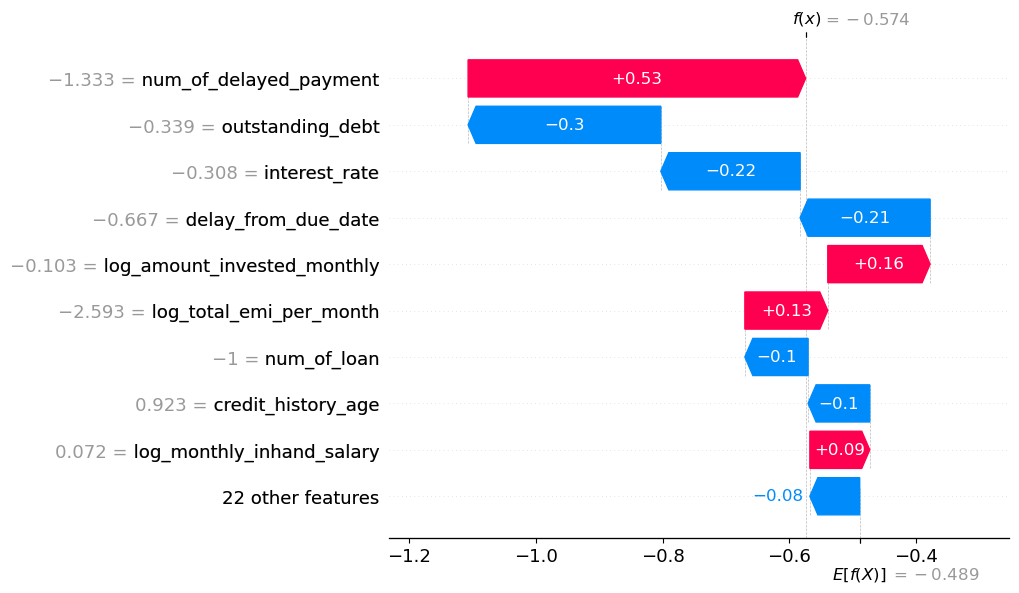


 Predicción: 0


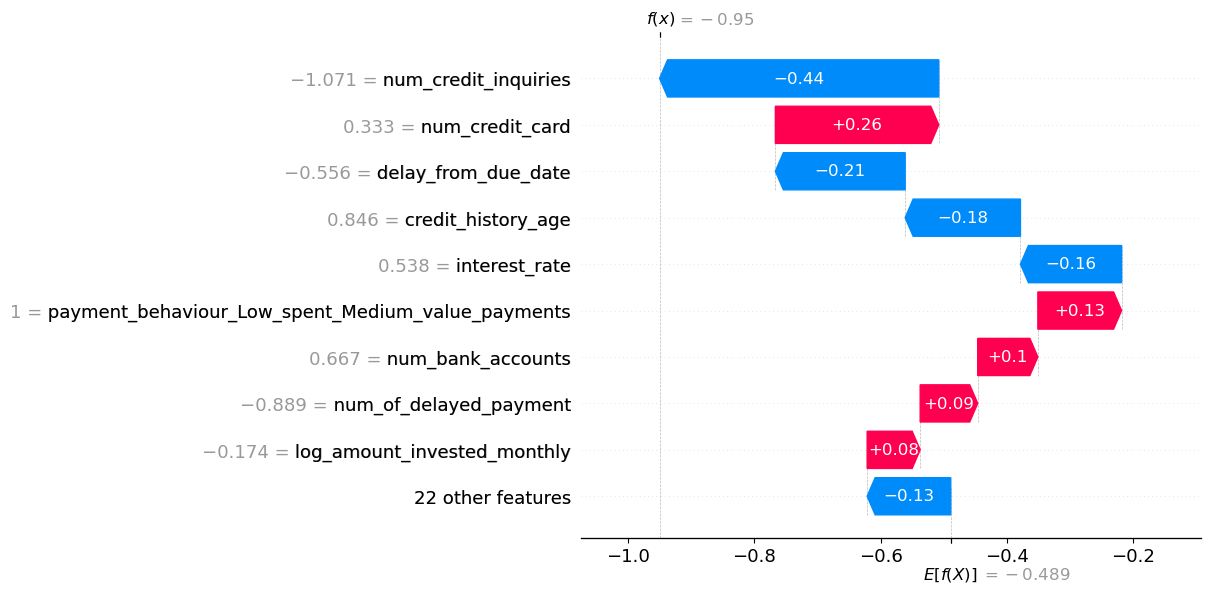


 Predicción: 0


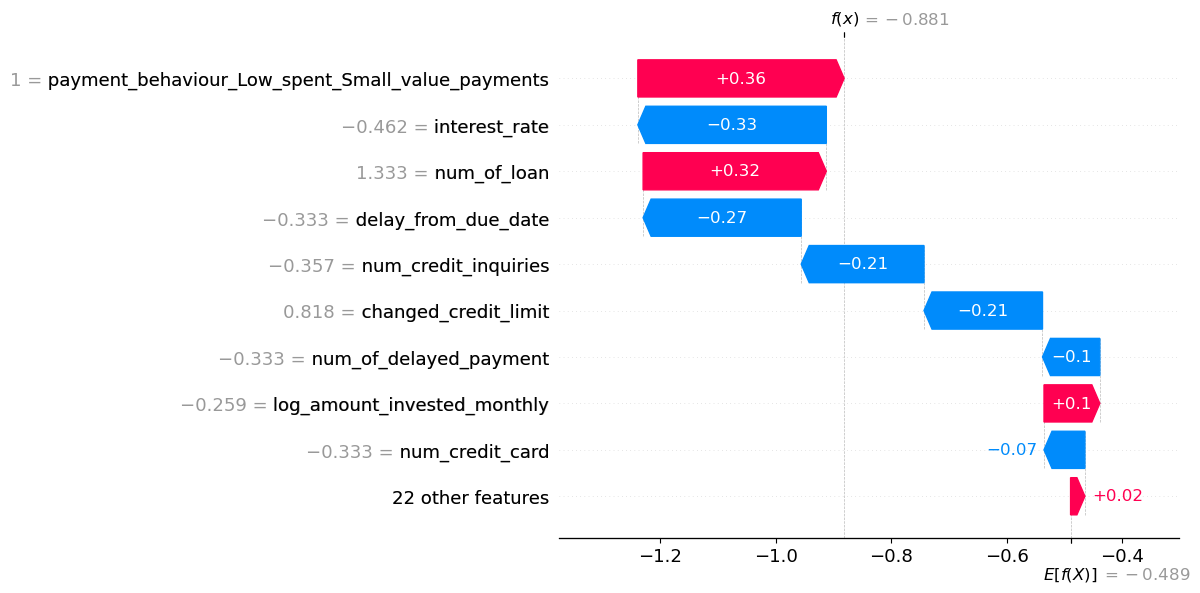


 Predicción: 1


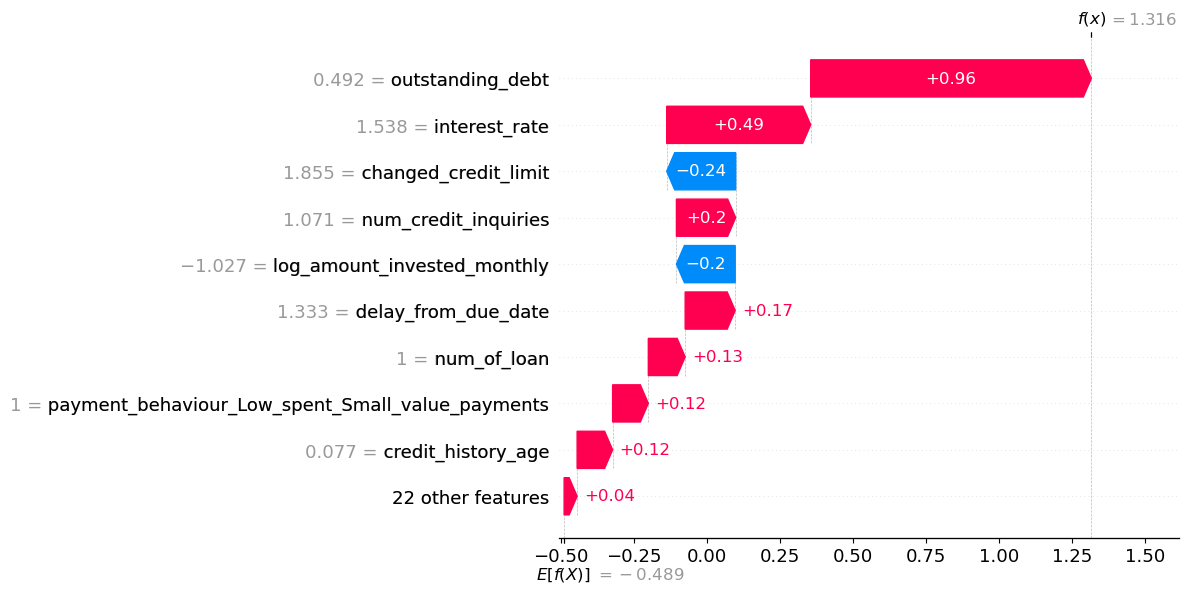


 Predicción: 0


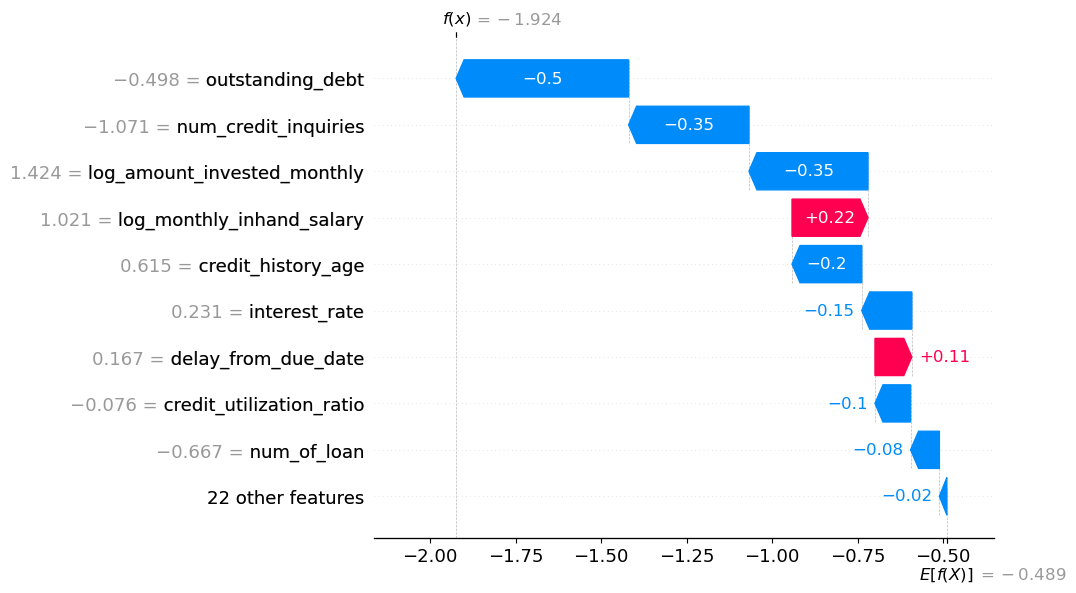


 Predicción: 0


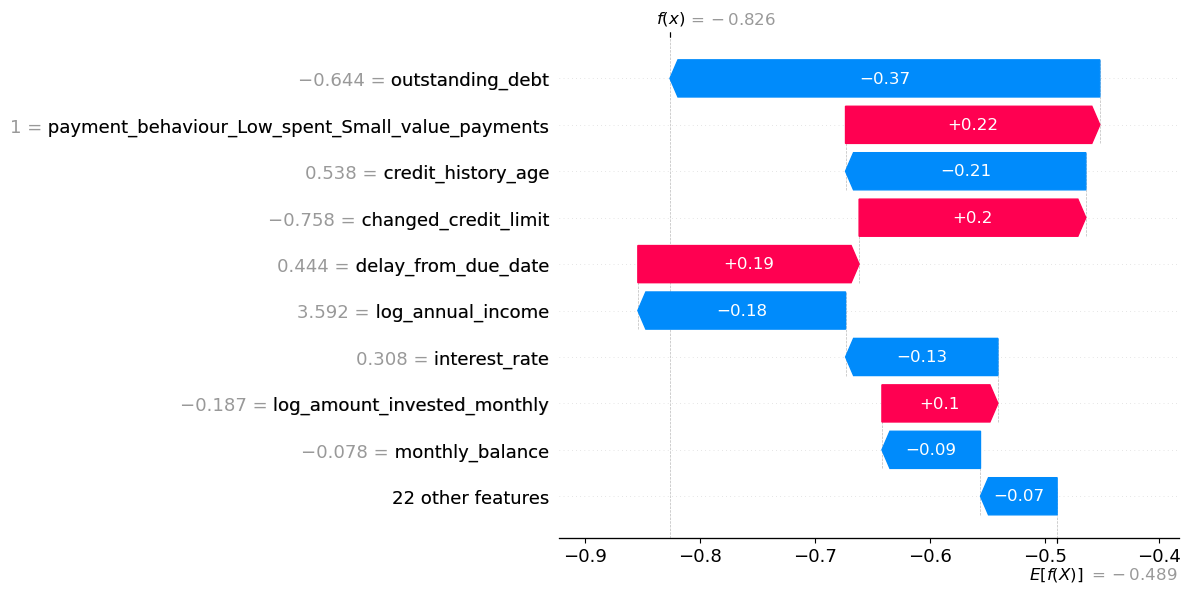


 Predicción: 0


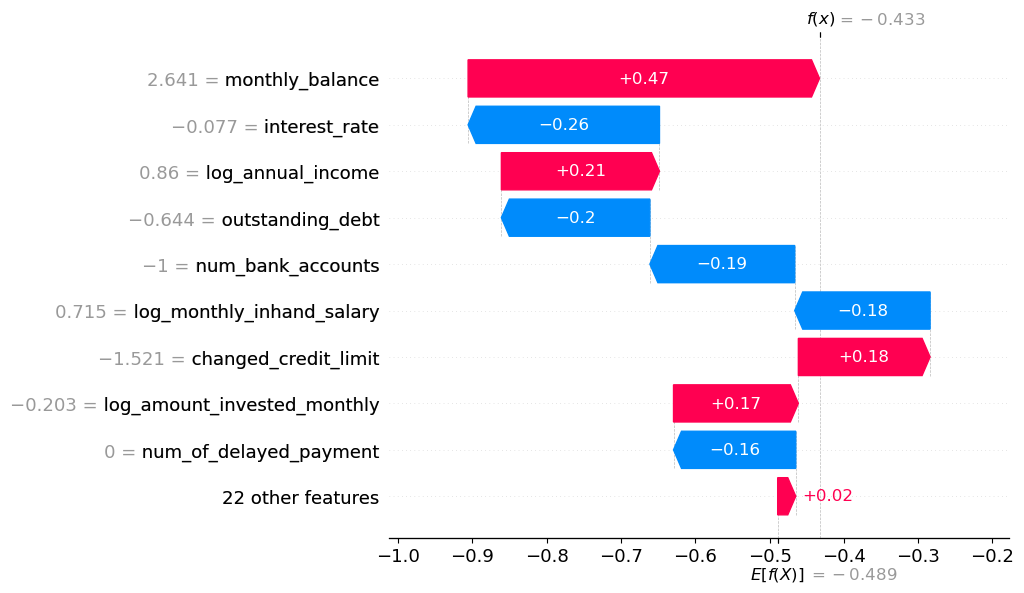


 Predicción: 1


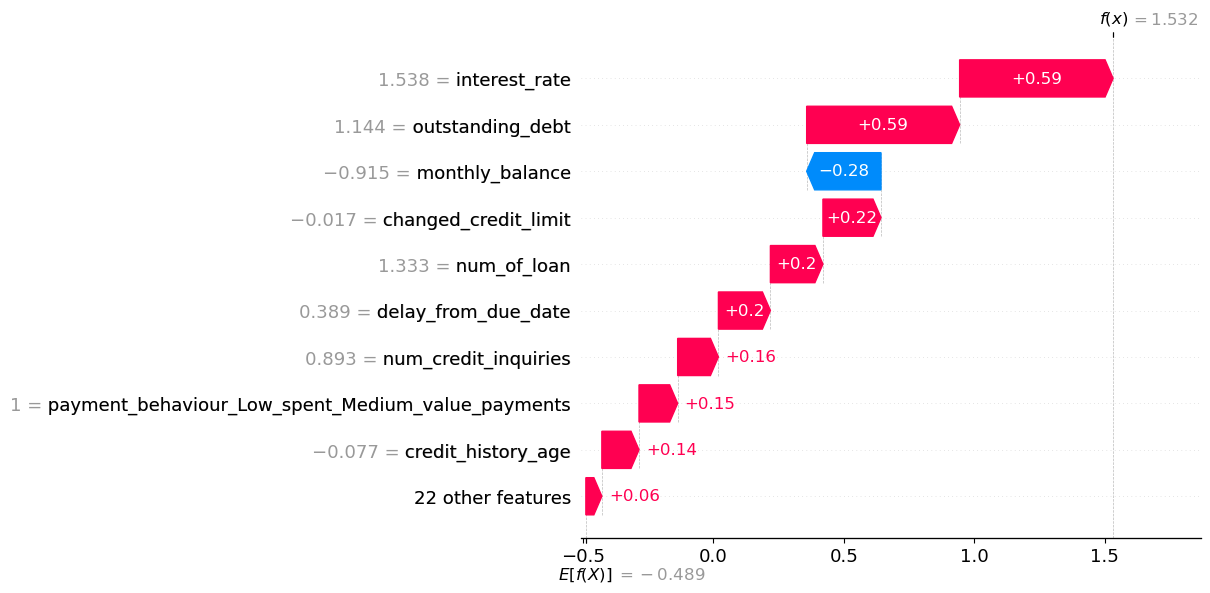


 Predicción: 0


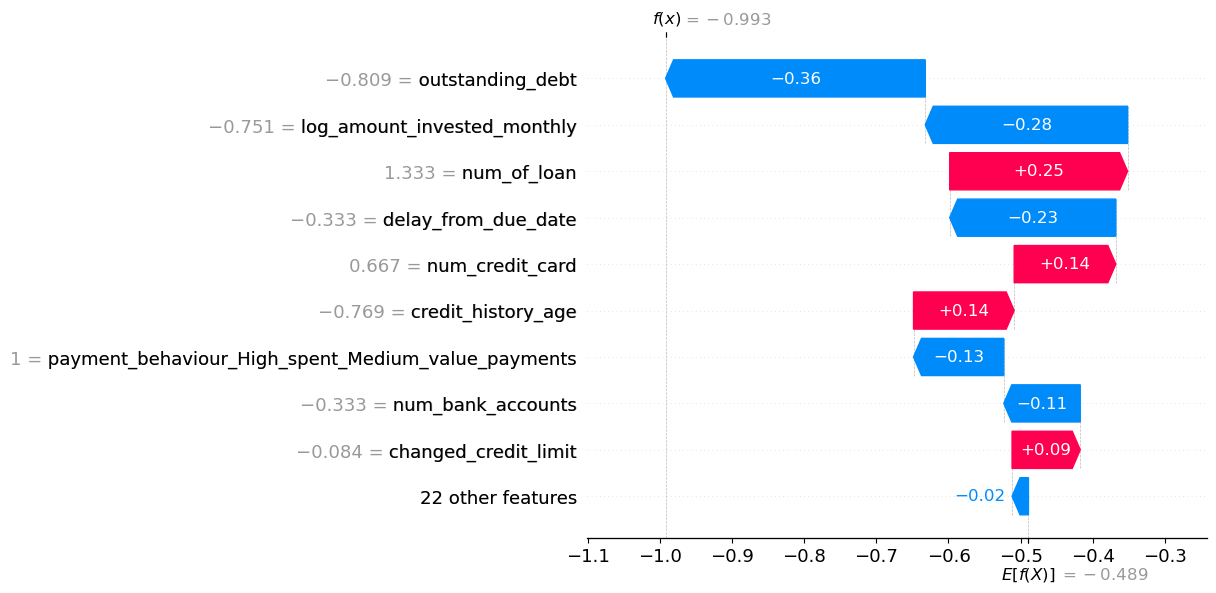


 Predicción: 0


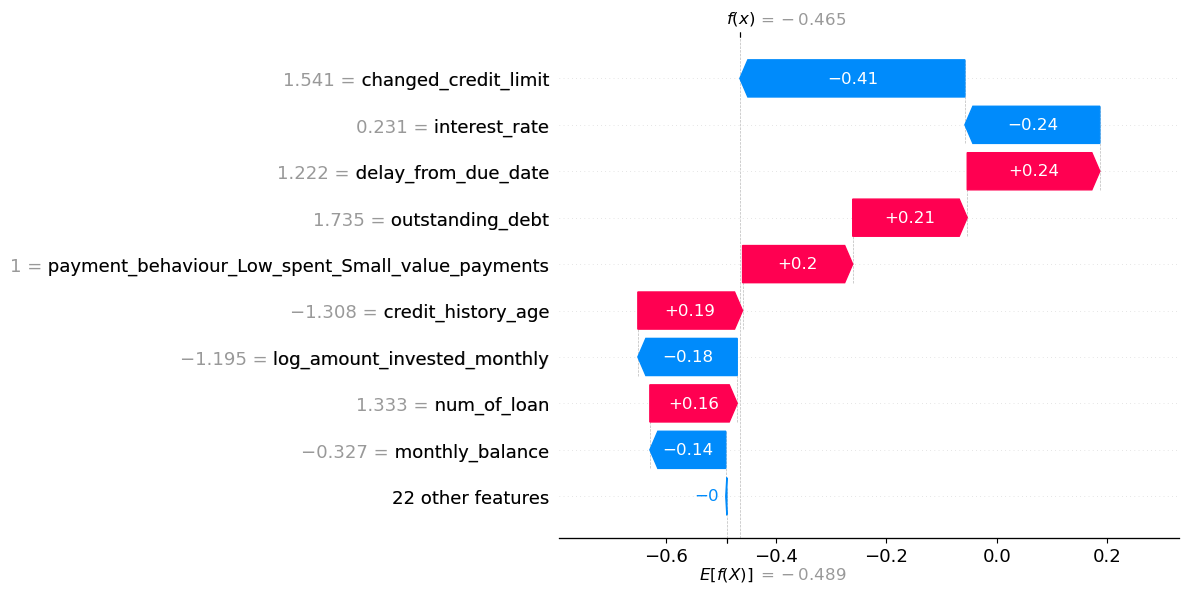

In [676]:
idx_sample_10 = np.random.choice(df.shape[0], 10)

for idx in idx_sample_10:
    print("\n", "Predicción:", lgbm_pipeline.predict(df)[idx])
    shap.plots.waterfall(shap_values[idx, :, 1])

Es posible observar que en ciertas instancias algunas variables cobran más relevancia que otras al momento de establecer el valor predicho por el modelo. Sin embargo es poisble encontrar ciertos patrones dentro de qué variables son las que son más importantes, como por ejemplo, aquellas variables asociadas a la deuda, atrasos de deuda, cantidad de veces que se ha solicitado un crédito, entre otras, por supuesto, del valor que tome cada variable, entendiéndose que a priori un cliente con un comportamiento menos errático representa una instancia de crédito más segura.

Veamos el aporte global de las variables en el modelo.

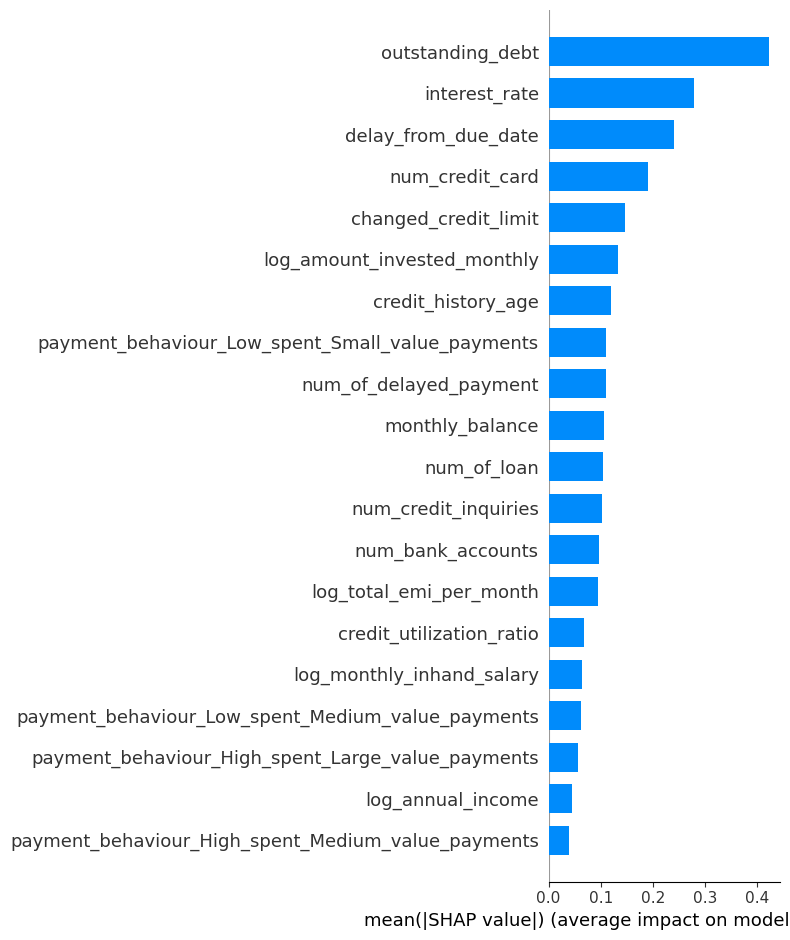

In [680]:
shap.summary_plot(
    shap_values[:, :, 1],
    pd.DataFrame(lgbm_pipeline[:-1].transform(df), columns=best_columns),
    plot_type="bar",
)

En términos de contribuciones absolutas de importancia por cada variable, es posible observar que las cinco variables más relevantes son:

- `outstanding_debt`
- `interest_rate`
- `delay_from_due_date`
- `num_credit_card`
- `changed_credit_limit`

Tal y como se habia discutido anteriormente, estas variables están asociadas a la deuda, atrasos de deuda, cantidad de veces que se ha solicitado un crédito, entre otras, por lo que es posible concluir que estas variables son las más relevantes para el modelo, y por lo tanto, son las variables que más influyen en la predicción del modelo.

## 7. Conclusión

A manera de resumen, se puede observar que los resultados obtenidos son aceptables, dado a que se logró obtener un `f1-score` de 0.6634 en el conjunto de validación, lo que es un resultado aceptable, considerando que el dataset es relativamente pequeño. Además, se puede observar que el modelo es capaz de predecir de manera adecuada la clase 1, la cual es la clase que indica que el cliente incumplirá su pago.

Sin embargo, se puede observar que el modelo no es capaz de predecir de manera adecuada la minoritaria, la cual es la clase que indica que el cliente no incumplirá su pago. Esto se puede deber a que el dataset está desbalanceado, lo que afecta el rendimiento de los modelos. Además, se puede observar que la métrica de `f1-score` asociada a la tarea en cuestión es la menor de todas las que se muestran en los reportes de los modelos, lo que indica que el modelo no es capaz de predecir de manera adecuada la clase minoritaria. Si bien las exactitudes promedio a nivel macro y micro son altas, esto puede no representar el verdadero _performance_, por lo que no es una métrica adecuada para evaluar el rendimiento de los modelos.

Sin dudas el análisis exploratorio de datos fue de gran ayuda para entender mejor los datos y poder generar un modelo que se ajuste de mejor manera a los datos. Además, el análisis de interpretabilidad fue de gran ayuda para entender mejor el comportamiento de los modelos y poder identificar posibles problemas en los datos, como por ejemplo la presencia de variables con ruido y _typos_.

Por otro lado, respecto a las diferencias de los modelos con respecto al baseline, se puede observar que los modelos son considerablemente mejores que el baseline, lo que indica que los modelos son aceptables, pero se podría mejorar con más tiempo de trabajo (como se mencionó anteriormente). Además, se puede observar que los modelos basados en árboles de decisión son los que mejor se ajustan a los datos, lo que es una ventaja en este caso, dado a que estos modelos son muy rápidos de entrenar y no requieren de una gran cantidad de datos para poder entrenarlos, lo que es una ventaja en este caso, dado a que el dataset es relativamente pequeño.

En este sentido, fue de gran ayuda además el uso de `Optuna` para optimizar los hiperparámetros de los modelos, lo que permitió mejorar el rendimiento de los modelos de manera considerable. A pesar de que esta mejora de rendimiento se viera reflejado solo en validación y no en prueba, esto se debe a que el dataset es relativamente pequeño, por lo que es posible que el conjunto de prueba no sea representativo de la población, lo que podría afectar el rendimiento de los modelos.

Personalmente no me considero conforme con los resultados, dado a que el `f1-score` obtenido es relativamente bajo. En este sentido podría haberme quedado con las métricas de `accuracy` y `precision` de la clase 0 con el fin de poder vender el modelo, pero esto no sería ético, dado a que el modelo no es capaz de predecir de manera adecuada la clase minoritaria, lo que podría afectar a don _Giturra_ en el futuro.

Por otro lado, se podría mejorar el rendimiento de los modelos utilizando técnicas de _oversampling_ y _undersampling_, lo que permitiría mejorar el rendimiento de los modelos, dado a que se podría balancear el dataset. Además, se podría mejorar el rendimiento de los modelos utilizando técnicas de _feature engineering_, lo que permitiría generar nuevas variables que podrían mejorar el rendimiento de los modelos. Por último, se podría mejorar el rendimiento de los modelos utilizando técnicas de _stacking_, lo que permitiría mejorar el rendimiento de los modelos, dado a que se podría combinar los modelos de manera más eficiente.